### __Model Building__

#### __Preparing data__

In [1]:
import pandas as pd
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random
import datetime

from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression as lr
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb

In [2]:
matplotlib.rcParams['figure.figsize'] = (25, 15)
matplotlib.rcParams['font.size'] = 10
random.seed(0)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [3]:
property_df = pd.read_csv(r"C:/Users/payoj.jain/Documents/projects/Europe Revenue estimation/data/X_data.csv")

In [4]:
property_df.head()

,Unnamed: 0,ACCOMMODATION_CODE,ACCOMMODATION_TYPE,ACCO_DESCRIPTION,NUMBER_OF_PERSONS,BEDROOM_COUNT,BATHROOM_COUNT,HAS_WIFI,HAS_POOL,HAS_PRIVATE_POOL,HAS_SHARED_POOL,HAS_INDOOR_POOL,HAS_OUTDOOR_POOL,IS_DETACHED,HAS_SAUNA,HAS_JACUZZI,IS_SKIING,IS_ON_A_FARM,X2017.x,X2018.x,X2019.x,X2017.y,X2018.y,X2019.y,total2019,total2018,total2017,Total_HO,Total_BV,LATITUDE,LONGITUDE,max,ELEVATION,if_near_coast,distance_from_coast,nearest_coastal_longitude,nearest_coastal_latitude,COUNTRY,price,bookings_count,weeks in 2017,weeks in 2018,weeks in 2019,weeks in 2020
0,0,AT-1050-01,1,Apartment,4,1,1,1,0,0,0,0,0,0,0,0,0,0,1068.4800,0.0,0.0,2627.118,432.358,0.0,0.0,432.358,3695.5980,3059.476,1068.4800,48.184128,16.367247,3695.5980,207.0,0,NaN,NaN,NaN,AT,0.0,1.0,NaN,NaN,NaN,NaN
1,1,AT-1115-01,3,Chalet,10,0,0,0,0,0,0,0,0,1,0,0,0,0,4474.4400,0.0,0.0,0.000,0.000,0.0,0.0,0.000,4474.4400,0.000,4474.4400,47.038075,10.610737,4474.4400,1444.0,0,NaN,NaN,NaN,AT,NaN,NaN,NaN,NaN,NaN,NaN
2,2,AT-1160-01,1,Apartment,2,2,1,1,0,0,0,0,0,0,0,0,0,0,358.3000,0.0,0.0,329.472,0.000,0.0,0.0,0.000,687.7720,329.472,358.3000,48.216322,16.312146,687.7720,232.0,0,NaN,NaN,NaN,AT,NaN,NaN,NaN,NaN,NaN,NaN
3,3,AT-1160-02,1,Apartment,2,1,1,1,0,0,0,0,0,0,0,0,0,0,518.9500,0.0,0.0,123.266,0.000,0.0,0.0,0.000,642.2160,123.266,518.9500,48.216322,16.312146,642.2160,232.0,0,NaN,NaN,NaN,AT,NaN,NaN,NaN,NaN,NaN,NaN
4,4,AT-1160-03,1,Apartment,4,3,1,1,0,0,0,0,0,0,0,0,0,0,2202.5825,0.0,0.0,430.144,0.000,0.0,0.0,0.000,2632.7265,430.144,2202.5825,48.216320,16.312150,2632.7265,232.0,0,NaN,NaN,NaN,AT,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Clipping outliers
def clipping_outliers(X_train, df, var):
    IQR = X_train[var].quantile(0.85)-X_train[var].quantile(0.15)
    lower_bound = X_train[var].quantile(0.15) - 4*IQR
    upper_bound = X_train[var].quantile(0.85) + 4*IQR
    no_outliers = len(df[df[var]>upper_bound]) + len(df[df[var]<lower_bound])
    print('There are %i outliers in %s: %.3f%%' %(no_outliers, var, no_outliers/len(df)))
    df[var] = df[var].clip(lower_bound, upper_bound)
    return df

In [6]:
property_df[(property_df["max"] == 0) & (property_df["COUNTRY"] == "DE") & (property_df["if_near_coast"] == 1)].count()["ACCOMMODATION_CODE"]

0

In [7]:
columns = ["ACCOMMODATION_CODE","ACCOMMODATION_TYPE", "NUMBER_OF_PERSONS", "BEDROOM_COUNT", "BATHROOM_COUNT", "HAS_WIFI", "HAS_POOL","HAS_PRIVATE_POOL", "HAS_SHARED_POOL", "IS_SKIING","total2019" ,"ELEVATION", "distance_from_coast", "weeks in 2019"]
# columns = ["NUMBER_OF_PERSONS", "BEDROOM_COUNT", "BATHROOM_COUNT", "HAS_WIFI", "HAS_POOL","HAS_PRIVATE_POOL", "IS_SKIING","max" ,"ELEVATION", "if_near_coast", "distance_from_coast", "price", "bookings_count"]

country_df = property_df[(property_df['COUNTRY'] == "DE") & (property_df["weeks in 2019"].notnull()) & (property_df["weeks in 2019"] > 0) & (property_df["total2019"].notnull())]
data_train = country_df[columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022DA9EEEF88>,
      dtype=object)

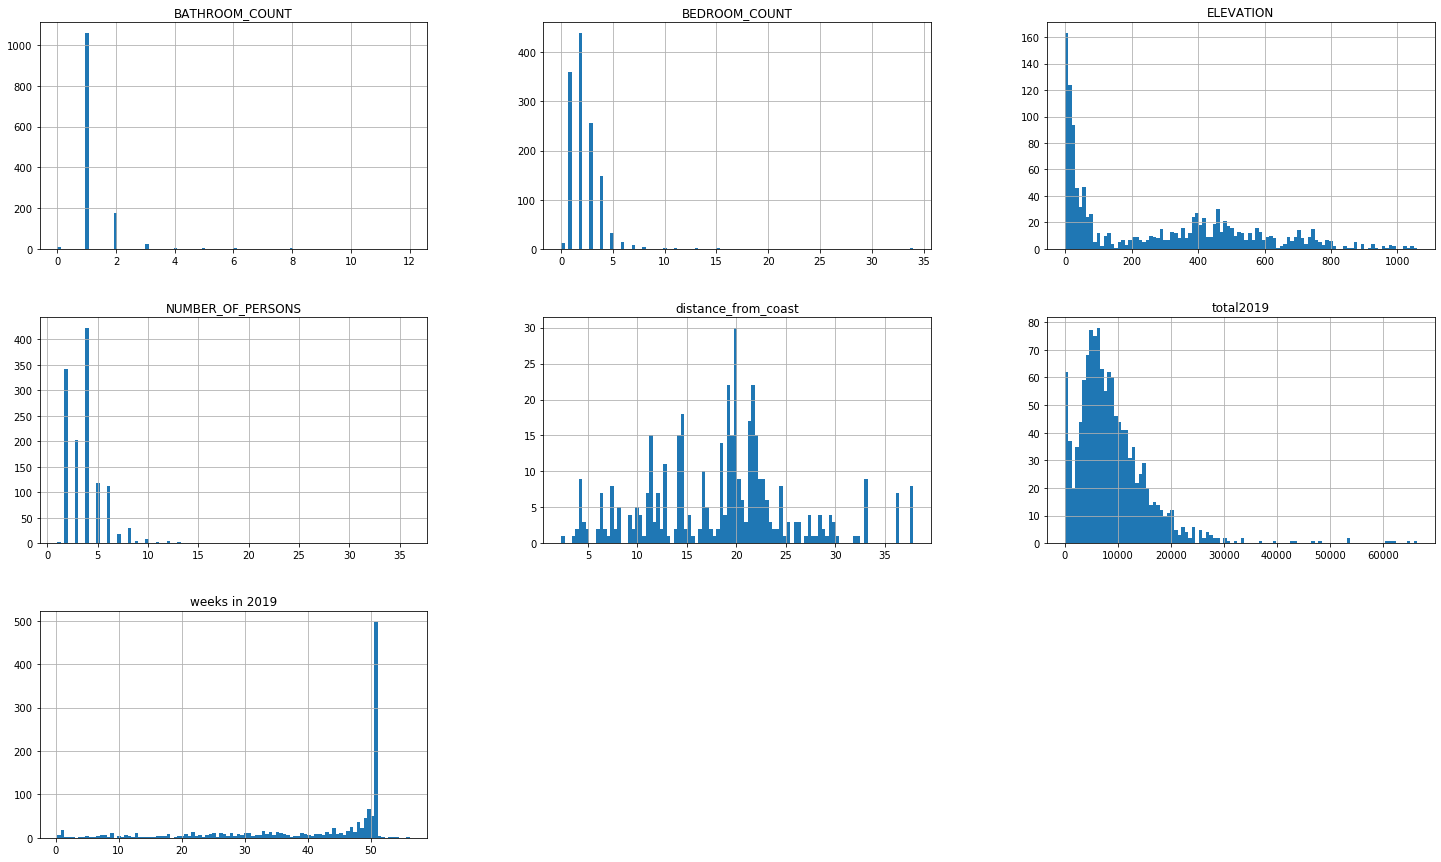

In [8]:
data_train[data_train["ACCOMMODATION_TYPE"]==1][["BATHROOM_COUNT", "BEDROOM_COUNT", "ELEVATION", "NUMBER_OF_PERSONS", "distance_from_coast", "total2019", "weeks in 2019"]].hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022DABD36388>,
      dtype=object)

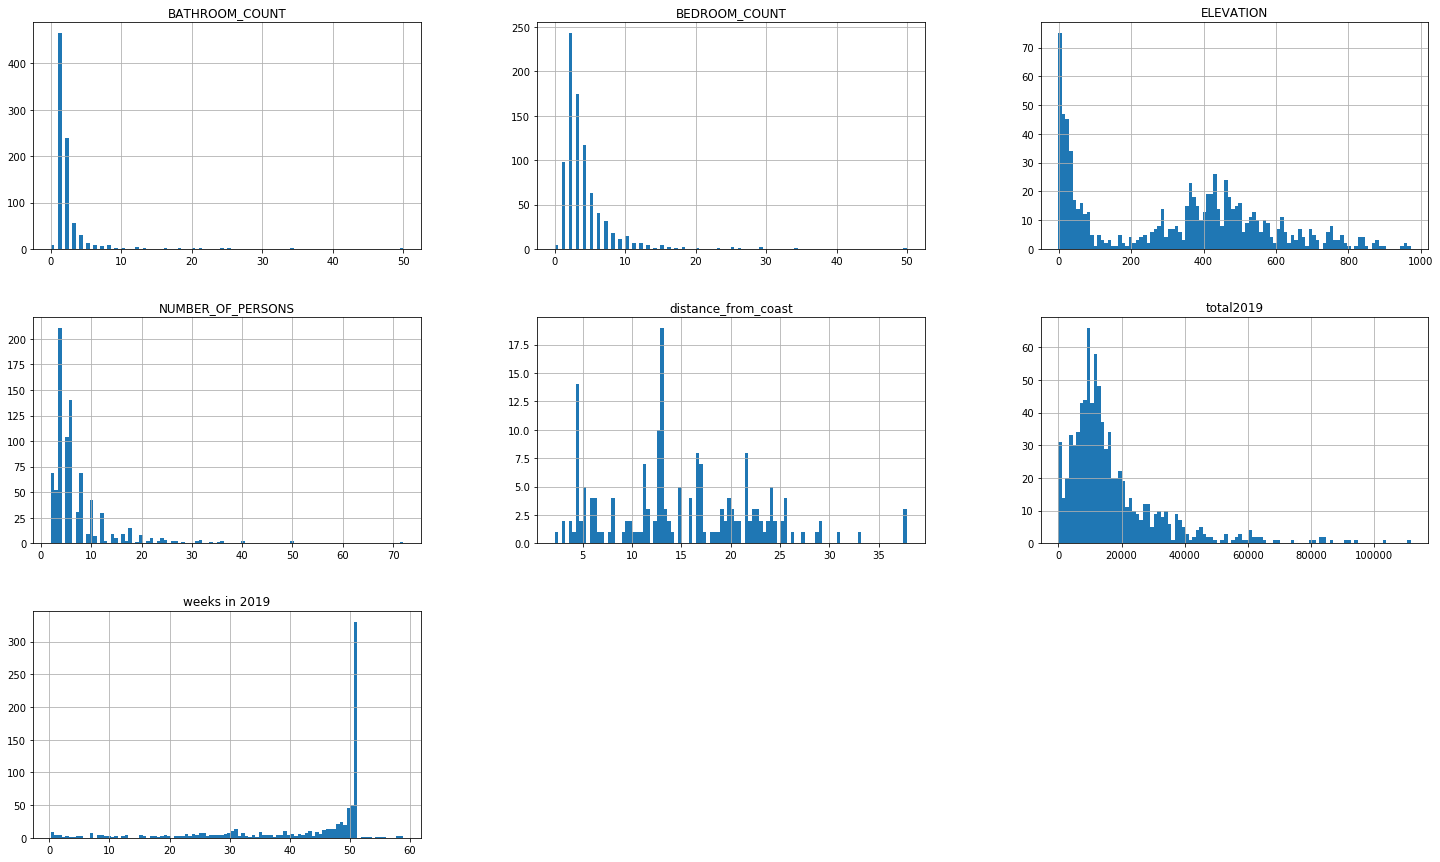

In [9]:
data_train[data_train["ACCOMMODATION_TYPE"]==2][["BATHROOM_COUNT", "BEDROOM_COUNT", "ELEVATION", "NUMBER_OF_PERSONS", "distance_from_coast", "total2019", "weeks in 2019"]].hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022DACD26C88>,
      dtype=object)

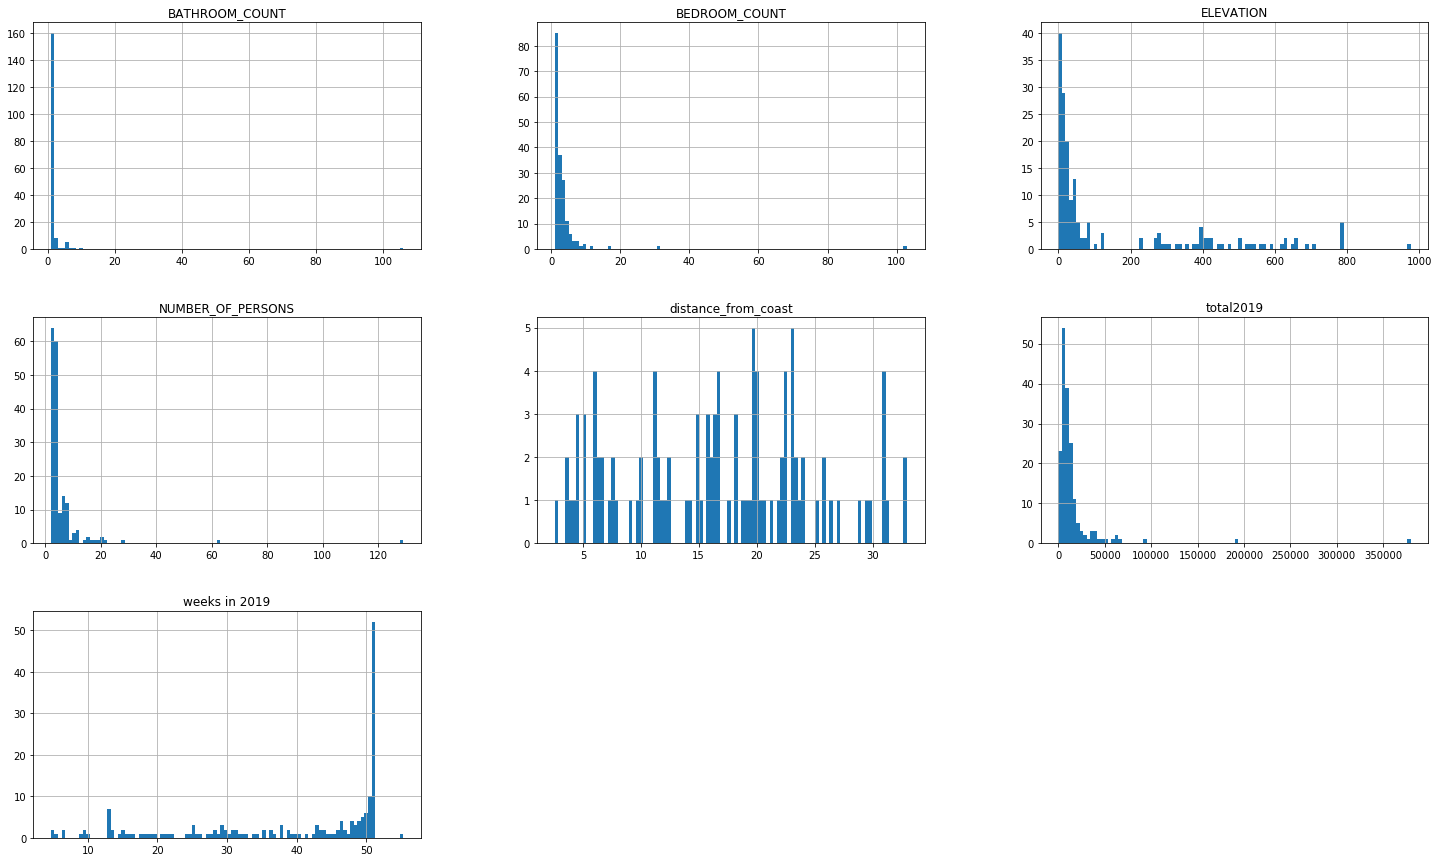

In [10]:
data_train[data_train["ACCOMMODATION_TYPE"]==3][["BATHROOM_COUNT", "BEDROOM_COUNT", "ELEVATION", "NUMBER_OF_PERSONS", "distance_from_coast", "total2019", "weeks in 2019"]].hist(bins=100)

In [11]:
# data_train['price'] = data_train['price'].fillna(0)
# data_train["bookings_count"] = data_train["bookings_count"].fillna(0)
data_train["distance_from_coast"] = data_train["distance_from_coast"].fillna(1000)
# data_train['total2018'] = data_train['total2018'].fillna(0)
# data_train = pd.get_dummies(data_train, columns=["ACCO_DESCRIPTION"], prefix=["ACCO_DESCRIPTION"])

In [12]:
for col in ["total2019"]:
    data_train = clipping_outliers(data_train, data_train, col)

There are 13 outliers in total2019: 0.006%


In [63]:
data_train[data_train["total2019"] == 0]

,ACCOMMODATION_CODE,ACCOMMODATION_TYPE,NUMBER_OF_PERSONS,BEDROOM_COUNT,BATHROOM_COUNT,HAS_WIFI,HAS_POOL,HAS_PRIVATE_POOL,HAS_SHARED_POOL,IS_SKIING,total2019,ELEVATION,distance_from_coast,weeks in 2019
4803,DE-00007-92,1,3,4,1,1,0,0,0,0,0.0,2.0,28.873983,1.000
5091,DE-00011-45,1,4,4,1,1,0,0,0,0,0.0,38.0,8.037601,0.857
5253,DE-00013-71,2,2,2,1,1,0,0,0,0,0.0,11.0,15.846108,15.847
5254,DE-00013-74-01,2,5,2,1,1,0,0,0,0,0.0,11.0,15.846108,24.625
5365,DE-00015-77,1,5,3,1,1,0,0,0,0,0.0,47.0,21.560999,0.286
5504,DE-00017-89,2,2,2,1,0,0,0,0,0,0.0,15.0,1000.000000,0.286
5578,DE-00019-85,1,4,2,1,1,0,0,0,0,0.0,6.0,14.280025,1.000
5580,DE-00019-87,1,4,2,1,1,0,0,0,0,0.0,6.0,14.280025,5.429
5581,DE-00019-89,1,4,2,1,1,0,0,0,0,0.0,6.0,14.280025,4.857
5667,DE-00022-78,1,4,2,1,1,0,0,0,0,0.0,148.0,1000.000000,7.000


In [14]:
len(data_train.values)

2310

In [15]:
# data_train = (data_train - data_train.mean())/data_train.std()

In [16]:
len(data_train.values)

2310

In [17]:
unused_cols = ['ACCOMMODATION_CODE', 'IS_SKIING', 'HAS_SHARED_POOL',
               'HAS_OUTDOOR_POOL', 'IS_DETACHED', 'HAS_SAUNA', 'HAS_JACUZZI', 
               'IS_ON_A_FARM', 'X2017.x', 'X2018.x', 'X2019.x', 'X2017.y',
               'X2018.y', 'X2019.y','max','total2018', 'total2017', 'total2019',
               'Total_HO','Total_BV', 'LATITUDE', 'LONGITUDE', 'max',
               'nearest_coastal_longitude','nearest_coastal_latitude', 'COUNTRY', 'bookings_count']
features = [col for col in data_train.columns if col not in unused_cols]
print(features)
train = data_train[features][:-80]
test = data_train[features][-80:]
train.to_csv(r"C:\Users\payoj.jain\Documents\projects\Europe Revenue estimation\data\train.csv")

['ACCOMMODATION_TYPE', 'NUMBER_OF_PERSONS', 'BEDROOM_COUNT', 'BATHROOM_COUNT', 'HAS_WIFI', 'HAS_POOL', 'HAS_PRIVATE_POOL', 'ELEVATION', 'distance_from_coast', 'weeks in 2019']


In [18]:
property_ids = pd.DataFrame(data_train['ACCOMMODATION_CODE'][:-80], columns=['ACCOMMODATION_CODE'])

In [19]:
property_ids.head()

,ACCOMMODATION_CODE
4764,DE-00000-77
4766,DE-00001-31
4767,DE-00001-50
4768,DE-00002-75
4772,DE-00003-69


In [20]:
target_revenue = data_train['total2019'][:-80]

In [21]:
test_target_revenue = data_train['total2019'][-80:]

In [22]:
test.head()

,ACCOMMODATION_TYPE,NUMBER_OF_PERSONS,BEDROOM_COUNT,BATHROOM_COUNT,HAS_WIFI,HAS_POOL,HAS_PRIVATE_POOL,ELEVATION,distance_from_coast,weeks in 2019
7542,2,4,2,2,0,0,0,710.0,1000.0,51.001
7543,2,5,3,1,0,0,0,536.0,1000.0,25.715
7544,2,4,2,1,0,0,0,476.0,1000.0,17.000
7545,2,3,1,1,0,0,0,496.0,1000.0,31.143
7546,2,2,1,1,1,0,0,470.0,1000.0,48.000


In [23]:
mean = target_revenue.mean()
std = target_revenue.std()
median = target_revenue.median()

In [24]:
lower_bound = mean - std
upper_bound = mean + std

In [25]:
mean, median, std, lower_bound, upper_bound

(12459.943317366919,
 9264.612000000001,
 12136.308892733683,
 323.63442463323554,
 24596.252210100603)

### __Modelling__

##### __Hyperparameter tuning__

#### __Fitting__

In [26]:
iterations = 25000
n_folds = 10

### __Approach 1 : LGBM__ 

In [27]:
model_revenue = lgb.LGBMRegressor(num_leaves=50,
                        max_depth=10,
                        learning_rate=0.05,
                        n_estimators=iterations,
                        min_child_samples=25,
                        subsample=0.75,
                        subsample_freq=1,
                        feature_fraction=0.75,
                        random_state=2019,
                        n_jobs=4,
                        metrics='mae',
                        lambda_l1= 0,
                        lambda_l2 = 0.2)

In [28]:
oof_train = np.zeros(shape=(len(train)))

### __Training__

#### __Revenue__

In [32]:
print("Training for revenue")
feature_importance_df_revenue = pd.DataFrame()
folds = KFold(n_splits=n_folds, shuffle=True, random_state=2019)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target_revenue.values)):
    print('Fold no %i/%i'%(fold_+1,n_folds))
    trn_data = train.iloc[trn_idx][features]
    trn_label = target_revenue.iloc[trn_idx]
    val_data = train.iloc[val_idx][features]
    val_label = target_revenue.iloc[val_idx]
    model_revenue.fit(X=trn_data, y=trn_label,
                     eval_set=[(trn_data, trn_label), (val_data, val_label)],
                     verbose=500,early_stopping_rounds=500)

    oof_train[val_idx] = model_revenue.predict(val_data)
#     print(oof_train[val_idx])
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = model_revenue.feature_importances_
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df_revenue = pd.concat([feature_importance_df_revenue, fold_importance_df], axis=0)

score = mean_absolute_error(oof_train[:], target_revenue)
print('Training CV score: %.5f' %score)

Training for revenue
Fold no 1/10
Training until validation scores don't improve for 500 rounds
[500]	training's l1: 2721.66	valid_1's l1: 4165.25
Early stopping, best iteration is:
[72]	training's l1: 3907.56	valid_1's l1: 4032.82
Fold no 2/10
Training until validation scores don't improve for 500 rounds
[500]	training's l1: 2620.38	valid_1's l1: 5146.8
Early stopping, best iteration is:
[139]	training's l1: 3506.12	valid_1's l1: 4917.92
Fold no 3/10
Training until validation scores don't improve for 500 rounds
[500]	training's l1: 2687.41	valid_1's l1: 4379.18
Early stopping, best iteration is:
[80]	training's l1: 3844.96	valid_1's l1: 4238.19
Fold no 4/10
Training until validation scores don't improve for 500 rounds
[500]	training's l1: 2675.58	valid_1's l1: 4410.11
Early stopping, best iteration is:
[141]	training's l1: 3543.3	valid_1's l1: 4336.7
Fold no 5/10
Training until validation scores don't improve for 500 rounds
[500]	training's l1: 2668.04	valid_1's l1: 4489.89
[1000]	tra

In [65]:
oof_train[4803]

IndexError: index 4803 is out of bounds for axis 0 with size 2230

In [35]:
result = np.zeros(len(test))
for i, value in enumerate(test.values):
    value = value.reshape(1,-1)
#     print(value)
    result[i] = model_revenue.predict(value)
score = mean_absolute_error(result, test_target_revenue)

In [36]:
score

3253.8761893223113

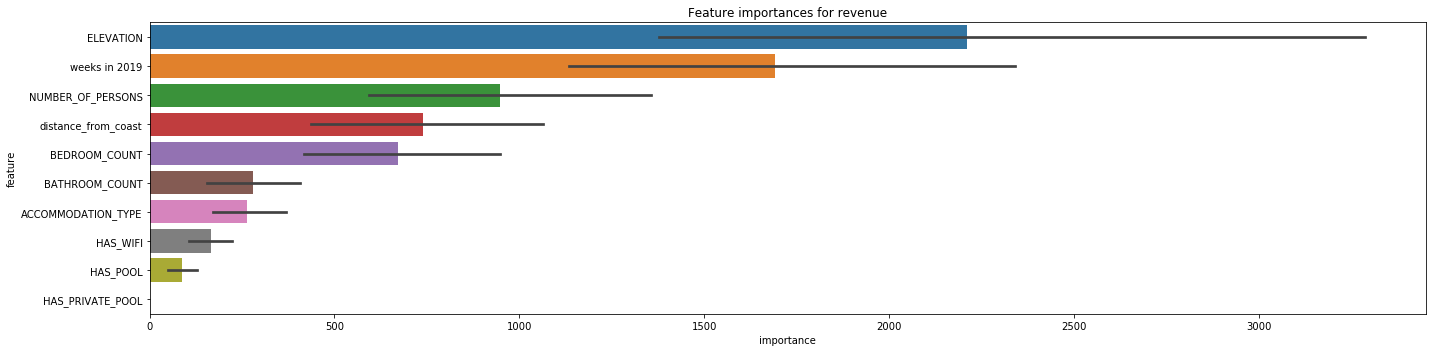

In [37]:
# Visualisation
cols = (feature_importance_df_revenue[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:25].index)

best_features = feature_importance_df_revenue.loc[feature_importance_df_revenue.feature.isin(cols)]

plt.figure(figsize=(20,5))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('Feature importances for revenue')
plt.tight_layout()

In [38]:
_error = (oof_train - target_revenue)/target_revenue

In [39]:
pred = pd.DataFrame(oof_train, columns={'predicted_revenue'})

In [40]:
print(pred.mean(), pred.median(), pred.std())

predicted_revenue    12469.627629
dtype: float64 predicted_revenue    9994.102519
dtype: float64 predicted_revenue    10048.852849
dtype: float64


In [41]:
count = 0 
for val in _error:
    if val < 3000:
        count+=1
accuracy = count/len(target_revenue)
accuracy

0.9874439461883409

In [42]:
ratio = oof_train/target_revenue

In [43]:
for i,r in enumerate(ratio):
    if r == float("inf") or r == float("-inf"):
        ratio.values[i] = 0.0

In [44]:
ratio.mean(), ratio.median(), ratio.std()

(1.4864675644892873, 1.0497599516422595, 2.5216143663447457)

In [45]:
total = len(ratio.values)

In [46]:
ratio = pd.DataFrame(ratio)
count = ratio[(ratio["total2019"] <= 1.3) & (ratio["total2019"] >= 0.70)].count()

In [47]:
count/total

total2019    0.480717
dtype: float64

In [48]:
property_df[property_df["ACCOMMODATION_CODE"] == "DE-06485-04"]

,Unnamed: 0,ACCOMMODATION_CODE,ACCOMMODATION_TYPE,ACCO_DESCRIPTION,NUMBER_OF_PERSONS,BEDROOM_COUNT,BATHROOM_COUNT,HAS_WIFI,HAS_POOL,HAS_PRIVATE_POOL,HAS_SHARED_POOL,HAS_INDOOR_POOL,HAS_OUTDOOR_POOL,IS_DETACHED,HAS_SAUNA,HAS_JACUZZI,IS_SKIING,IS_ON_A_FARM,X2017.x,X2018.x,X2019.x,X2017.y,X2018.y,X2019.y,total2019,total2018,total2017,Total_HO,Total_BV,LATITUDE,LONGITUDE,max,ELEVATION,if_near_coast,distance_from_coast,nearest_coastal_longitude,nearest_coastal_latitude,COUNTRY,price,bookings_count,weeks in 2017,weeks in 2018,weeks in 2019,weeks in 2020
5824,5824,DE-06485-04,2,Holiday home,7,4,2,0,0,0,0,0,0,1,0,0,0,0,11657.10133,18071.80667,103.24,2168.635,3464.199,0.0,103.24,21536.00567,13825.73633,5632.834,29832.148,51.723387,11.155955,21536.00567,242.0,0,NaN,NaN,NaN,DE,78.983782,18.0,1.0,52.0,12.572,0.0


In [49]:
property_ids["pred/gbv"] = ratio

In [50]:
property_ids["error"] = _error

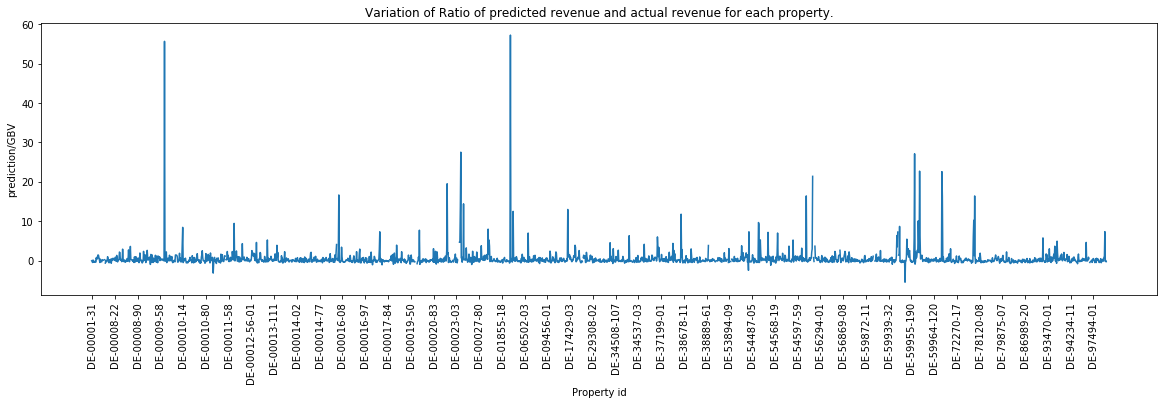

In [51]:
plt.figure(figsize=(20,5))
plt.plot(property_ids["ACCOMMODATION_CODE"], property_ids["error"])
plt.xlabel("Property id")
plt.ylabel("prediction/GBV")
plt.xticks(property_ids["ACCOMMODATION_CODE"][1::50],rotation=90)
plt.title("Variation of Ratio of predicted revenue and actual revenue for each property.")
# plt.ylim(0,20)
plt.show()

In [52]:
property_ids[property_ids["error"]> 75]

,ACCOMMODATION_CODE,pred/gbv,error
4803,DE-00007-92,0.0,inf
5091,DE-00011-45,0.0,inf
5253,DE-00013-71,0.0,inf
5254,DE-00013-74-01,0.0,inf
5365,DE-00015-77,0.0,inf
5504,DE-00017-89,0.0,inf
5578,DE-00019-85,0.0,inf
5580,DE-00019-87,0.0,inf
5581,DE-00019-89,0.0,inf
5667,DE-00022-78,0.0,inf


In [53]:
merge = pd.merge(property_ids, property_df, on="ACCOMMODATION_CODE", how="left")
# merge[merge["pred/gbv"] > 75]
merge["predicted"] = merge["pred/gbv"]*merge["total2019"]

In [54]:
anamolies = merge[merge["pred/gbv"]>2][["ACCOMMODATION_CODE", "pred/gbv", "error", "total2019", "predicted", "max"]]
anamolies.to_csv("anamolies.csv")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022DAD6C2E88>,
      dtype=object)

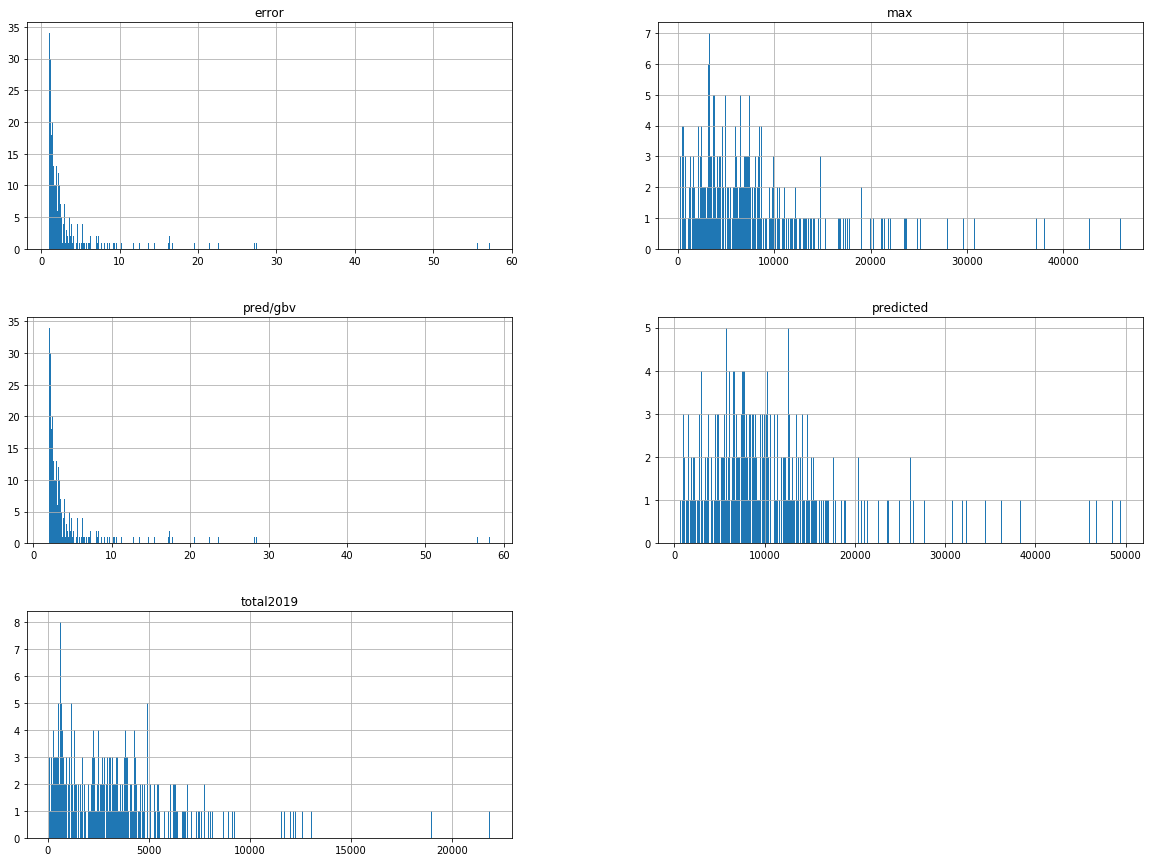

In [55]:
anamolies.hist(bins=500, figsize=(20,15))

In [56]:
property_ids.quantile([0, .1, .25, .5, .75, 1], axis=0)

,pred/gbv,error
0.00,-4.495262,NaN
0.10,0.574189,-0.406623
0.25,0.776910,-0.208173
0.50,1.049760,0.064282
0.75,1.495506,0.527596
1.00,58.262120,NaN


In [57]:
for i,e in enumerate(_error):
    if e == float("inf") or e == float("-inf"):
        _error.values[i] = 0

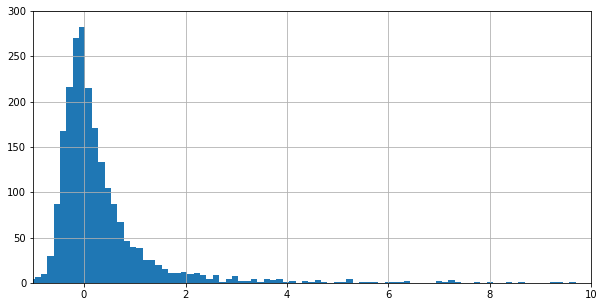

In [58]:
plt.figure(figsize=(10,5))
plt.axis([-1,10, 0, 300])
_error.hist(bins=500)

In [59]:
0.2*target_revenue.mean()

2491.988663473384

In [60]:
bins = np.linspace(-10, 10, 100)

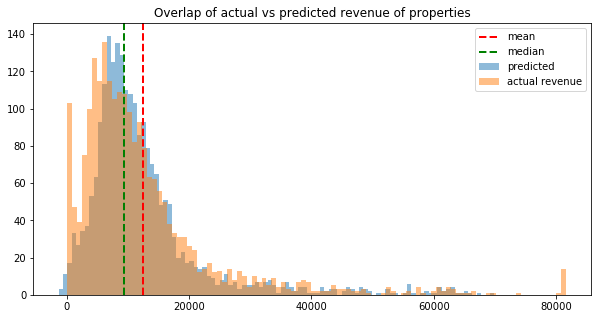

In [61]:
plt.figure(figsize=(10,5))
plt.hist(oof_train, bins=100, alpha=0.5, label='predicted')
plt.hist(target_revenue, bins=100, alpha=0.5, label='actual revenue')
plt.axvline(target_revenue.mean(), color='red', linestyle='dashed', linewidth=2, label="mean")
plt.axvline(target_revenue.median(), color='green', linestyle='dashed', linewidth=2, label="median")
plt.legend(loc='upper right')
plt.title("Overlap of actual vs predicted revenue of properties")
plt.show()

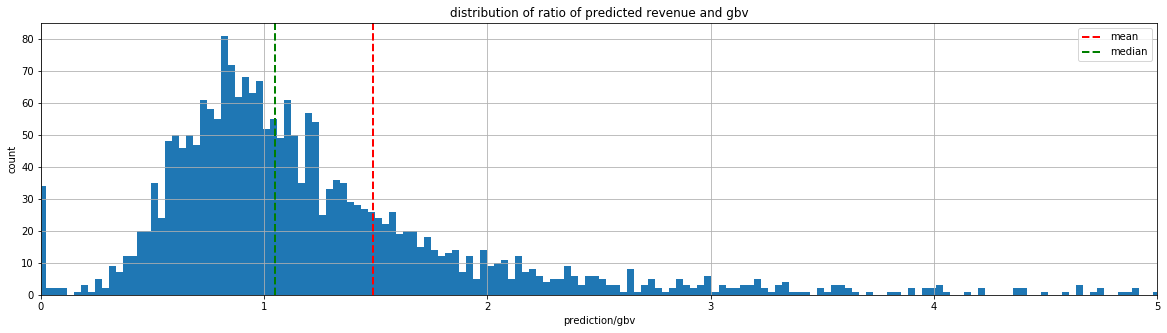

In [62]:
# plt.figure(figsize=(8,5))
ratio.hist(bins=2000, figsize=(20,5))
# plt.legend(loc='upper right')
plt.axvline(ratio.mean().values, color='red', linestyle='dashed', linewidth=2, label="mean")
plt.axvline(ratio.median().values, color='green', linestyle='dashed', linewidth=2, label="median")
plt.xlim(0,5)
plt.xlabel("prediction/gbv")
plt.ylabel("count")
plt.legend(loc="upper right")
plt.title("distribution of ratio of predicted revenue and gbv")
plt.show()